Training Neural Networks

In [ ]:
# The MNIST datasets are hosted on yann.lecun.com that has moved under CloudFlare protection
# Run this script to enable the datasets download
# Reference: https://github.com/pytorch/vision/issues/1938

from six.moves import urllib
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)

In [2]:
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,)),
                              ])
# Download and load the training data
trainset = datasets.MNIST('~/datasets/MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

In [3]:
# Feed forward network

model = nn.Sequential(nn.Linear(784, 128),
                      nn.ReLU(),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Linear(64, 10))

# Define the loss
criterion = nn.CrossEntropyLoss()

# data
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Flatten images

images = images.view(images.shape[0], -1)

# Forward pass, get our logits
logits = model(images)

# Calculate the loss with the logits and the labels
loss = criterion(logits, labels)

print(loss)

tensor(2.2985, grad_fn=<NllLossBackward0>)


Exercise: Build a model that returns the log-softmax as the output and calculate the loss using the negative log likelihood loss. Note that for nn.LogSoftmax and F.log_softmax you'll need to set the dim keyword argument appropriately. dim=0 calculates softmax across the rows, so each column sums to 1, while dim=1 calculates across the columns so each row sums to 1. Think about what you want the output to be and choose dim appropriately

In [4]:
model = nn.Sequential(nn.Linear(784, 128),
                        nn.ReLU(),
                        nn.Linear(128, 64),
                        nn.ReLU(),
                        nn.Linear(64, 10),
                        nn.LogSoftmax(dim=1))

criterion = nn.NLLLoss()

images, labels = next(dataiter)
images = images.view(images.shape[0], -1)

logits = model(images)
loss = criterion(logits, labels)

print(loss)

tensor(2.3254, grad_fn=<NllLossBackward0>)


# Autograd

Torch provides a module, autograd, for automatically calculating the gradients of tensors. We can use it to calculate the gradients of all our parameters with respect to the loss. 

Autograd works by keeping track of operations performed on tensors, then going backwards through those operations, calculating gradients along the way. 

To make sure PyTorch keeps track of operations on a tensor and calculates the gradients, you need to set requires_grad = True on a tensor.

When we create a network with PyTorch, all of the parameters are initialized with requires_grad = True. 

This means that when we calculate the loss and call loss.backward(), the gradients for the parameters are calculated. 

These gradients are used to update the weights with gradient descent.

# Training the network!

Exercise: Implement the training pass for our network. If you implemented it correctly, you should see the training loss drop with each epoch.

In [5]:
model = nn.Sequential(nn.Linear(784, 128),
                      nn.ReLU(),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Linear(64, 10),
                      nn.LogSoftmax(dim=1))

criterion = nn.NLLLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

epochs = 5

for e in range(epochs):

    running_loss = 0

    for images, labels in trainloader:

        images = images.view(images.shape[0], -1)

        optimizer.zero_grad()

        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    else:
        print(f"Training loss: {running_loss/len(trainloader)}")

Training loss: 1.0532687181380511
Training loss: 0.380118625028047
Training loss: 0.3236379891252721
Training loss: 0.29320797182000014
Training loss: 0.2695615015892205


In [12]:
import matplotlib.pyplot as plt
import numpy as np

In [13]:

def view_classify(img, ps, version="MNIST"):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    if version == "MNIST":
        ax2.set_yticklabels(np.arange(10))
    elif version == "Fashion":
        ax2.set_yticklabels(['T-shirt/top',
                            'Trouser',
                            'Pullover',
                            'Dress',
                            'Coat',
                            'Sandal',
                            'Shirt',
                            'Sneaker',
                            'Bag',
                            'Ankle Boot'], size='small');
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

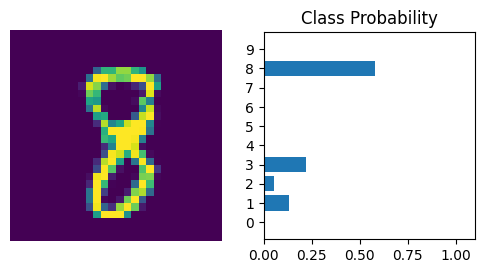

In [16]:
# Cehck the predictions

%matplotlib inline

dataiter = iter(trainloader)
images, labels = next(dataiter)

img = images[0].view(1, 784)

with torch.no_grad():
    logits = model(img)

# Output of the network are logits, need to take softmax for probabilities
ps = F.softmax(logits, dim=1)

view_classify(img.view(1, 28, 28), ps)